# Reconstruction of plant--pollinator networks from observational data 

A tutorial on how to use our [Stan](http://mc-stan.org) model to infer the structure and properties of real ecosystems from noisy, error-prone measurements.
Based on the article "*[Reconstruction of plant–pollinator networks from observational data](https://doi.org/10.1038/s41467-021-24149-x)*"<br/> [J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).


*Authors*: J.-G. Young <jgyou@umich.edu>, adapted for pystan3 by S. Dritz <sjdritz@ucdavis.edu> <br/>
*Last update*: April 2022 <br/>

---

**Important Note:** In this notebook, I assume that you have installed `pystan`, version 3.0 and above, and will interact with the model in `python3` (check the [README](README.md) file otherwise). `Stan` also has a [R interface](https://cran.r-project.org/web/packages/rstan/index.html), for which we do not provide helper functions.
That said, all what we show here should easily be transferable to the `R` version of `Stan`!
The only purpose of our python code is to manipulate the samples once they have been generated by `Stan`.

---

## Loading data and modules

First, let's import some required modules: 'pystan `numpy` and `pyplot` to handle the model the data and visualize our results.
We'll also import the custom helper modules `utilities` (load / save / compress / sort data matrices) and `plant_pol_inference` (interact with model, draw samples, compute estimates).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference_pystan3 as pp
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

We'll use the data matrix shown in the paper as an example. 
It comes from the Supplementary information of [this paper by Kaiser-Bunbury et al. [Nature **542**, 2017]](https://www.nature.com/articles/nature21071). It records the number of interactions between 8 plant species and 21 pollinator species. This is for a single ecosystem, as observed over the course of one month.

In [2]:
M = np.loadtxt('example_matrix.txt').astype('int')
M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

Let's visualize it:

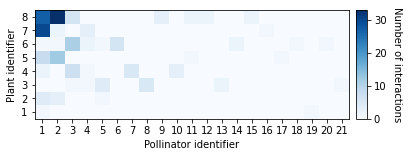

In [3]:
plt.figure(figsize=(6,2))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [4]:
with open('model_pystan3.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  array[n_p, n_a] int<lower=0> M;
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  array[n_p] int M_rows = rep_array(0, n_p);
  array[n_a] int M_cols = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Prior
  r ~ exponential(0.01);

  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains... well.. the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [5]:
model = pp.compile_stan_model(M, random_seed = 1)

[Compiling]
Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9

In file included from /home/jgyou/.local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:7,
                 from /home/jgyou/.cache/httpstan/4.7.2/models/4t7eflu4/model_4t7eflu4.cpp:2:
/home/jgyou/.local/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp: In member function ‘virtual std::vector<std::complex<double> > stan::io::dump::vals_c(const string&) const’:
/home/jgyou/.local/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<double, std::allocator<double> >::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
  694 |       for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
      |                                          ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~
/home/jgyou/.local/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison of integer expressions of different sign

Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s


/home/jgyou/.cache/httpstan/4.7.2/models/4t7eflu4/model_4t7eflu4.cpp: In instantiation of ‘void model_4t7eflu4_namespace::model_4t7eflu4::transform_inits_impl(VecVar&, VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_std_vector_t<T>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/jgyou/.cache/httpstan/4.7.2/models/4t7eflu4/model_4t7eflu4.cpp:675:26:   required from here
/home/jgyou/.cache/httpstan/4.7.2/models/4t7eflu4/model_4t7eflu4.cpp:453:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  453 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~


Building: 8.5s
Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s
Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s


In file included from /home/jgyou/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun.hpp:158,
                 from /home/jgyou/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/jgyou/.local/lib/python3.10/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/jgyou/.local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/jgyou/.cache/httpstan/4.7.2/models/4t7eflu4/model_4t7eflu4.cpp:2:
/home/jgyou/.local/lib/python3.10/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp: In instantiation of ‘auto stan::math::simplex_constrain(const T&, stan::scalar_type_t<T>&) [with T = Eigen::Map<Eigen::Matrix<stan::math::var_value<double>, -1, 1>, 0, Eigen::Stride<0, 0> >; stan::require_rev_col_vector_t<T>* <anonymous> = 0; stan::scalar_type_t<T> = stan::math::var_value<double>]’:
/home/jgyou/.local/lib/python3.10/site-packages/https

Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.5s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s
Building: 15.0s
Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.0s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s
Building: 16.6s
Building: 16.7s
Building: 16.8s
Building: 16.9s
Building

Building: 22.2s, done.
Messages from stanc:
Warning in '/tmp/httpstan_5w7lpzm9/model_4t7eflu4.stan', line 45, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Warning in '/tmp/httpstan_5w7lpzm9/model_4t7eflu4.stan', line 29, column 18: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).


Warnings about our parameters having no priors can be ignored because when no priors are specified, the model automatically uses uniform priors.

## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [6]:
samples = pp.generate_sample(model, num_warmup=2000, num_samples=500)

Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   2% (203/10000)
Sampling:   7% (702/10000)
Sampling:   9% (901/10000)
Sampling:  11% (1100/10000)
Sampling:  15% (1500/10000)
Sampling:  21% (2100/10000)
Sampling:  24% (2400/10000)
Sampling:  27% (2700/10000)
Sampling:  32% (3200/10000)
Sampling:  39% (3900/10000)
Sampling:  42% (4200/10000)
Sampling:  48% (4800/10000)
Sampling:  62% (6200/10000)
Sampling:  69% (6900/10000)
Sampling:  86% (8600/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000253 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000247 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.47 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00023

We can see by plotting the value of the posterior distribution, evaluated for each samples, that at least one chain has gotten stuck in a minima.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

Text(0, 0.5, 'log posterior')

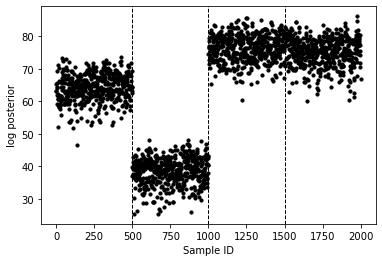

In [7]:
# re-sort data so that it can be easiliy visualized by chain
chains = [1, 2, 3, 4] * 500
log_probs = np.column_stack((chains, samples['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(2000), log_probs[:,1], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')

In this particular case, one chain has gotten stuck in an optima with lower posterior probability.

We'll re-run the sampling until we get a clean sample:

In [8]:
while not pp.test_samples(samples, tol=0.05):
    model = pp.compile_stan_model(M)
    samples = pp.generate_sample(model, num_warmup=2000, num_samples=500)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_5w7lpzm9/model_4t7eflu4.stan', line 45, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Warning in '/tmp/httpstan_5w7lpzm9/model_4t7eflu4.stan', line 29, column 18: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%


[Average Log-Probability Per Chain]
[64.82638007 38.54787435 74.68316434 74.1075197 ]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   7% (701/10000)
Sampling:  12% (1200/10000)
Sampling:  16% (1600/10000)
Sampling:  19% (1900/10000)
Sampling:  24% (2400/10000)
Sampling:  29% (2900/10000)
Sampling:  35% (3500/10000)
Sampling:  38% (3800/10000)
Sampling:  43% (4300/10000)
Sampling:  49% (4900/10000)
Sampling:  55% (5500/10000)
Sampling:  58% (5800/10000)
Sampling:  69% (6900/10000)
Sampling:  78% (7800/10000)
Sampling:  86% (8600/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000117 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.17 seconds.
  Adjust your expectations accordingly!
  Gradient evaluat

[Average Log-Probability Per Chain]
[75.32831811 35.12132504 54.68412152 37.91423728]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   4% (401/10000)
Sampling:   9% (900/10000)
Sampling:  14% (1400/10000)
Sampling:  16% (1600/10000)
Sampling:  19% (1900/10000)
Sampling:  25% (2500/10000)
Sampling:  31% (3100/10000)
Sampling:  35% (3500/10000)
Sampling:  38% (3800/10000)
Sampling:  45% (4500/10000)
Sampling:  51% (5100/10000)
Sampling:  61% (6100/10000)
Sampling:  71% (7100/10000)
Sampling:  78% (7800/10000)
Sampling:  85% (8500/10000)
Sampling:  92% (9200/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 5.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accord

[Average Log-Probability Per Chain]
[76.18271283 76.05156907 39.21210473 38.61528071]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   2% (203/10000)
Sampling:   7% (702/10000)
Sampling:   9% (901/10000)
Sampling:  11% (1100/10000)
Sampling:  15% (1500/10000)
Sampling:  21% (2100/10000)
Sampling:  24% (2400/10000)
Sampling:  27% (2700/10000)
Sampling:  31% (3100/10000)
Sampling:  37% (3700/10000)
Sampling:  40% (4000/10000)
Sampling:  46% (4600/10000)
Sampling:  55% (5500/10000)
Sampling:  63% (6300/10000)
Sampling:  80% (8000/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 7.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation t

[Average Log-Probability Per Chain]
[64.82638007 38.54787435 74.68316434 74.1075197 ]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   1% (102/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   5% (501/10000)
Sampling:   9% (901/10000)
Sampling:  11% (1100/10000)
Sampling:  15% (1500/10000)
Sampling:  17% (1700/10000)
Sampling:  24% (2400/10000)
Sampling:  27% (2700/10000)
Sampling:  31% (3100/10000)
Sampling:  35% (3500/10000)
Sampling:  41% (4100/10000)
Sampling:  45% (4500/10000)
Sampling:  53% (5300/10000)
Sampling:  60% (6000/10000)
Sampling:  67% (6700/10000)
Sampling:  74% (7400/10000)
Sampling:  81% (8100/10000)
Sampling:  91% (9100/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000116 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.52 seconds.
  

[Average Log-Probability Per Chain]
[75.18931565 75.85098301 37.92222635 76.91378508]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   1% (102/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   5% (501/10000)
Sampling:   9% (901/10000)
Sampling:  11% (1100/10000)
Sampling:  16% (1600/10000)
Sampling:  21% (2100/10000)
Sampling:  27% (2700/10000)
Sampling:  29% (2900/10000)
Sampling:  33% (3300/10000)
Sampling:  37% (3700/10000)
Sampling:  43% (4300/10000)
Sampling:  47% (4700/10000)
Sampling:  61% (6100/10000)
Sampling:  75% (7500/10000)
Sampling:  83% (8300/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000113 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000112 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 7.3e-05 seconds
  

[Average Log-Probability Per Chain]
[57.26251753 58.22575457 38.8881694  75.81731031]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   1% (103/10000)
Sampling:   4% (402/10000)
Sampling:   7% (701/10000)
Sampling:  12% (1200/10000)
Sampling:  16% (1600/10000)
Sampling:  20% (2000/10000)
Sampling:  25% (2500/10000)
Sampling:  30% (3000/10000)
Sampling:  36% (3600/10000)
Sampling:  40% (4000/10000)
Sampling:  44% (4400/10000)
Sampling:  49% (4900/10000)
Sampling:  55% (5500/10000)
Sampling:  60% (6000/10000)
Sampling:  73% (7300/10000)
Sampling:  83% (8300/10000)
Sampling:  91% (9100/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000138 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluat

[Average Log-Probability Per Chain]
[58.68386969 58.54064829 55.58211051 38.04032204]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   5% (501/10000)
Sampling:   9% (900/10000)
Sampling:  14% (1400/10000)
Sampling:  16% (1600/10000)
Sampling:  18% (1800/10000)
Sampling:  22% (2200/10000)
Sampling:  28% (2800/10000)
Sampling:  32% (3200/10000)
Sampling:  36% (3600/10000)
Sampling:  41% (4100/10000)
Sampling:  47% (4700/10000)
Sampling:  57% (5700/10000)
Sampling:  68% (6800/10000)
Sampling:  80% (8000/10000)
Sampling:  87% (8700/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000129 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.29 seconds.
  Adjust your expectations acco

[Average Log-Probability Per Chain]
[75.80564695 76.77329771 59.28953749 38.94819297]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   3% (303/10000)
Sampling:   5% (502/10000)
Sampling:   7% (701/10000)
Sampling:   9% (900/10000)
Sampling:  14% (1400/10000)
Sampling:  16% (1600/10000)
Sampling:  19% (1900/10000)
Sampling:  22% (2200/10000)
Sampling:  27% (2700/10000)
Sampling:  30% (3000/10000)
Sampling:  33% (3300/10000)
Sampling:  36% (3600/10000)
Sampling:  41% (4100/10000)
Sampling:  44% (4400/10000)
Sampling:  52% (5200/10000)
Sampling:  59% (5900/10000)
Sampling:  66% (6600/10000)
Sampling:  73% (7300/10000)
Sampling:  75% (7500/10000)
Sampling:  78% (7800/10000)
Sampling:  86% (8600/10000)
Sampling:  93% (9300/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000112 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation

[Average Log-Probability Per Chain]
[49.74020194 75.07027147 76.63948712 75.93254007]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   1% (102/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   6% (601/10000)
Sampling:  11% (1101/10000)
Sampling:  14% (1400/10000)
Sampling:  17% (1700/10000)
Sampling:  23% (2300/10000)
Sampling:  28% (2800/10000)
Sampling:  30% (3000/10000)
Sampling:  34% (3400/10000)
Sampling:  40% (4000/10000)
Sampling:  46% (4600/10000)
Sampling:  49% (4900/10000)
Sampling:  58% (5800/10000)
Sampling:  67% (6700/10000)
Sampling:  75% (7500/10000)
Sampling:  84% (8400/10000)
Sampling:  86% (8600/10000)
Sampling:  87% (8700/10000)
Sampling:  93% (9300/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00012 seconds
  1000 transitions using 10 leapfrog steps per transition

[Average Log-Probability Per Chain]
[75.16306486 38.2753465  37.55978426 76.38915323]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   5% (500/10000)
Sampling:   9% (900/10000)
Sampling:  12% (1200/10000)
Sampling:  15% (1500/10000)
Sampling:  18% (1800/10000)
Sampling:  24% (2400/10000)
Sampling:  27% (2700/10000)
Sampling:  30% (3000/10000)
Sampling:  33% (3300/10000)
Sampling:  39% (3900/10000)
Sampling:  43% (4300/10000)
Sampling:  49% (4900/10000)
Sampling:  55% (5500/10000)
Sampling:  63% (6300/10000)
Sampling:  69% (6900/10000)
Sampling:  71% (7100/10000)
Sampling:  73% (7300/10000)
Sampling:  75% (7500/10000)
Sampling:  85% (8500/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
  Adjust your expectations accordingly!
  Gradient evaluatio

[Average Log-Probability Per Chain]
[74.75188992 75.19971638 73.82853371 38.42205265]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   8% (801/10000)
Sampling:  10% (1000/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  20% (2000/10000)
Sampling:  23% (2300/10000)
Sampling:  26% (2600/10000)
Sampling:  30% (3000/10000)
Sampling:  34% (3400/10000)
Sampling:  37% (3700/10000)
Sampling:  39% (3900/10000)
Sampling:  42% (4200/10000)
Sampling:  47% (4700/10000)
Sampling:  54% (5400/10000)
Sampling:  62% (6200/10000)
Sampling:  70% (7000/10000)
Sampling:  76% (7600/10000)
Sampling:  86% (8600/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000116 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000118 seconds
  10

[Average Log-Probability Per Chain]
[76.23267588 75.24235933 53.37485904 74.38933578]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   8% (801/10000)
Sampling:  10% (1000/10000)
Sampling:  13% (1300/10000)
Sampling:  16% (1600/10000)
Sampling:  22% (2200/10000)
Sampling:  24% (2400/10000)
Sampling:  28% (2800/10000)
Sampling:  31% (3100/10000)
Sampling:  37% (3700/10000)
Sampling:  40% (4000/10000)
Sampling:  46% (4600/10000)
Sampling:  53% (5300/10000)
Sampling:  61% (6100/10000)
Sampling:  66% (6600/10000)
Sampling:  69% (6900/10000)
Sampling:  72% (7200/10000)
Sampling:  74% (7400/10000)
Sampling:  76% (7600/10000)
Sampling:  83% (8300/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluatio

[Average Log-Probability Per Chain]
[75.79996308 75.45194334 38.33667107 74.72442349]
[Compiling]


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_5w7lpzm9/model_4t7eflu4.stan', line 45, column 6: A
    control flow statement depends on parameter(s): C, r, rho, sigma, tau.
Warning in '/tmp/httpstan_5w7lpzm9/model_4t7eflu4.stan', line 29, column 18: Argument
    0.01 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Sampling:   0%


[Average Log-Probability Per Chain]
[76.18271283 76.05156907 39.21210473 38.61528071]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   4% (403/10000)
Sampling:   8% (802/10000)
Sampling:  10% (1001/10000)
Sampling:  12% (1200/10000)
Sampling:  18% (1800/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  29% (2900/10000)
Sampling:  35% (3500/10000)
Sampling:  41% (4100/10000)
Sampling:  44% (4400/10000)
Sampling:  63% (6300/10000)
Sampling:  72% (7200/10000)
Sampling:  83% (8300/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000118 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.18 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.51 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000122 seconds
  1000 transitions using 10 leapf

[Average Log-Probability Per Chain]
[37.47080723 50.5181382  76.26614353 64.84668447]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   5% (501/10000)
Sampling:   7% (700/10000)
Sampling:  10% (1000/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  19% (1900/10000)
Sampling:  23% (2300/10000)
Sampling:  27% (2700/10000)
Sampling:  30% (3000/10000)
Sampling:  35% (3500/10000)
Sampling:  40% (4000/10000)
Sampling:  45% (4500/10000)
Sampling:  48% (4800/10000)
Sampling:  53% (5300/10000)
Sampling:  59% (5900/10000)
Sampling:  70% (7000/10000)
Sampling:  85% (8500/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition w

[Average Log-Probability Per Chain]
[57.76067792 76.67020363 65.67024125 54.01150728]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   3% (302/10000)
Sampling:   5% (501/10000)
Sampling:   9% (900/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  18% (1800/10000)
Sampling:  23% (2300/10000)
Sampling:  27% (2700/10000)
Sampling:  29% (2900/10000)
Sampling:  32% (3200/10000)
Sampling:  38% (3800/10000)
Sampling:  43% (4300/10000)
Sampling:  46% (4600/10000)
Sampling:  49% (4900/10000)
Sampling:  59% (5900/10000)
Sampling:  70% (7000/10000)
Sampling:  86% (8600/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000114 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.5 seconds.
  Adjust y

[Average Log-Probability Per Chain]
[59.49937814 76.07676372 75.4672118  53.6504713 ]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   1% (102/10000)
Sampling:   2% (202/10000)
Sampling:   5% (501/10000)
Sampling:   7% (700/10000)
Sampling:  12% (1200/10000)
Sampling:  16% (1600/10000)
Sampling:  20% (2000/10000)
Sampling:  23% (2300/10000)
Sampling:  29% (2900/10000)
Sampling:  35% (3500/10000)
Sampling:  40% (4000/10000)
Sampling:  43% (4300/10000)
Sampling:  50% (5000/10000)
Sampling:  56% (5600/10000)
Sampling:  69% (6900/10000)
Sampling:  86% (8600/10000)
Sampling:  92% (9200/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000112 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.54 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000184 seconds
 

[Average Log-Probability Per Chain]
[59.56261208 76.40635292 38.28302487 38.89637402]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   2% (203/10000)
Sampling:   5% (502/10000)
Sampling:   7% (701/10000)
Sampling:   9% (900/10000)
Sampling:  12% (1200/10000)
Sampling:  17% (1700/10000)
Sampling:  20% (2000/10000)
Sampling:  23% (2300/10000)
Sampling:  26% (2600/10000)
Sampling:  31% (3100/10000)
Sampling:  35% (3500/10000)
Sampling:  38% (3800/10000)
Sampling:  42% (4200/10000)
Sampling:  48% (4800/10000)
Sampling:  56% (5600/10000)
Sampling:  63% (6300/10000)
Sampling:  70% (7000/10000)
Sampling:  76% (7600/10000)
Sampling:  84% (8400/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000113 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 5.2e-05 seconds
  1000 transitions using 10 leapfr

[Average Log-Probability Per Chain]
[76.70797039 48.61896835 75.58660369 75.54305324]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   5% (502/10000)
Sampling:  10% (1001/10000)
Sampling:  12% (1200/10000)
Sampling:  15% (1500/10000)
Sampling:  19% (1900/10000)
Sampling:  25% (2500/10000)
Sampling:  28% (2800/10000)
Sampling:  31% (3100/10000)
Sampling:  37% (3700/10000)
Sampling:  43% (4300/10000)
Sampling:  46% (4600/10000)
Sampling:  53% (5300/10000)
Sampling:  64% (6400/10000)
Sampling:  72% (7200/10000)
Sampling:  82% (8200/10000)
Sampling:  87% (8700/10000)
Sampling:  88% (8800/10000)
Sampling:  94% (9400/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 5.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.56 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000115 seconds
  1000 transitions using 10 leapfrog steps per transition wo

[Average Log-Probability Per Chain]
[74.37240802 49.75846622 38.92394022 75.87262772]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   4% (401/10000)
Sampling:   6% (600/10000)
Sampling:   9% (900/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  17% (1700/10000)
Sampling:  20% (2000/10000)
Sampling:  22% (2200/10000)
Sampling:  26% (2600/10000)
Sampling:  29% (2900/10000)
Sampling:  32% (3200/10000)
Sampling:  35% (3500/10000)
Sampling:  38% (3800/10000)
Sampling:  41% (4100/10000)
Sampling:  44% (4400/10000)
Sampling:  48% (4800/10000)
Sampling:  51% (5100/10000)
Sampling:  54% (5400/10000)
Sampling:  58% (5800/10000)
Sampling:  62% (6200/10000)
Sampling:  66% (6600/10000)
Sampling:  70% (7000/10000)
Sampling:  78% (7800/10000)
Sampling:  86% (8600/10000)
Sampling:  93% (9300/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation took 0.000111 seconds
  100

[Average Log-Probability Per Chain]
[75.78984125 77.47129773 75.62737793 74.45752676]


After a few attempts we find a nice set of samples:

Text(0, 0.5, 'log posterior')

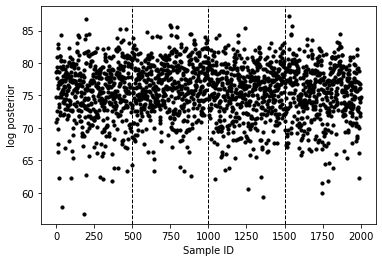

In [9]:
# re-sort data so that it can be easiliy visualized by chain
chains = [1, 2, 3, 4] * 500
log_probs = np.column_stack((chains, samples['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(2000), log_probs[:,1], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')

Here's the summary of our succesful sampling procedure:

In [10]:
samples.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,C,r,sigma.1,...,Q.7.20,Q.8.20,Q.1.21,Q.2.21,Q.3.21,Q.4.21,Q.5.21,Q.6.21,Q.7.21,Q.8.21
draws,,,,,,,,,,,,,,,,,,,,,
0,78.550691,0.935727,0.143123,5.0,31.0,0.0,-64.873605,26.685230,34.477415,0.021176,...,0.006057,0.012851,0.055894,0.110409,0.058004,0.000008,0.011952,1.373813e-09,1.812547e-06,0.000022
1,76.559735,0.970260,0.130115,5.0,31.0,0.0,-56.805130,26.534162,22.477542,0.007183,...,0.000099,0.000602,0.220562,0.215757,0.840151,0.163429,0.201983,1.320043e-01,1.378234e-01,0.154468
2,74.100351,0.905590,0.139569,5.0,31.0,0.0,-59.937641,9.476218,77.083007,0.009205,...,0.295138,0.302786,0.231592,0.080729,0.719287,0.000008,0.004111,1.447980e-09,5.892967e-07,0.000003
3,81.093903,0.998159,0.137716,5.0,31.0,0.0,-65.252871,14.386207,45.400139,0.015972,...,0.117867,0.118957,0.235021,0.243766,0.900641,0.014787,0.113341,1.810054e-03,1.141472e-02,0.011795
4,80.958338,0.939971,0.143123,5.0,31.0,0.0,-68.165900,12.599667,44.717938,0.024130,...,0.000702,0.000490,0.330166,0.336746,0.953131,0.260002,0.306030,2.504998e-01,2.555546e-01,0.251317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,78.726049,1.000000,0.137716,4.0,15.0,0.0,-60.562549,22.182444,35.183717,0.091599,...,0.185557,0.173488,0.225901,0.255288,0.914381,0.187424,0.245156,1.751934e-01,2.049949e-01,0.195509
1996,66.999451,0.888120,0.143123,5.0,31.0,0.0,-50.380810,17.523780,38.997938,0.035341,...,0.147504,0.145566,0.171768,0.233872,0.557428,0.005795,0.141505,3.356557e-02,5.073028e-02,0.048707
1997,75.418688,0.964253,0.130115,4.0,31.0,0.0,-64.891624,27.293115,44.962845,0.076249,...,0.005340,0.024756,0.004765,0.104654,0.519175,0.000037,0.023476,7.341590e-08,3.116426e-06,0.000335


We now have well-behaved samples, let's move on to model checking and estimation.

## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [11]:
M_tilde = pp.get_posterior_predictive_matrix(samples)

Let's compare it with the input

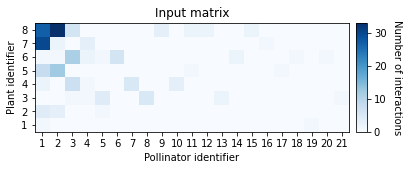

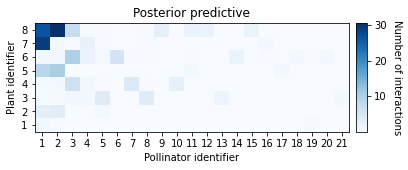

In [12]:
plt.figure(figsize=(6,2))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');
plt.figure(figsize=(6,2))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


They are quite close!

More systematically we can check the distribution of the differences between the posterior predictive and the input:

Text(0, 0.5, 'Count')

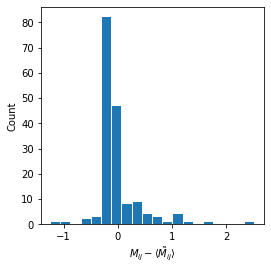

In [13]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')

Or compare the posterior predictive value to the input directly:

(-4.9, 38.0)

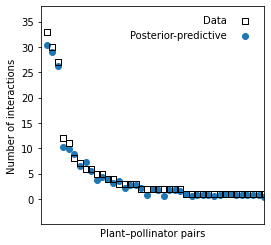

In [14]:
plt.figure(figsize=(4,4))
sort_order = np.argsort(-M.flatten())

plt.scatter(range(1, len(sort_order)+1), M.flatten()[sort_order], marker='s', facecolors='none', edgecolors='k', label='Data')
plt.scatter(range(1, len(sort_order)+1), M_tilde.flatten()[sort_order], label='Posterior-predictive', zorder=-10)

plt.xlim(0,40)
plt.xlabel('Plant–pollinator pairs')
plt.xticks([])
plt.ylabel(r'Number of interactions')
plt.legend(frameon=False, markerfirst=False, loc=1)
plt.ylim(-4.9,38)

All these point of view confirm one thing: The model fits well.

Which means we're ready to calculate some estimates.

## Estimates

We provide a simple function to get the network estimate:

In [15]:
edge_prob = pp.estimate_network(samples)

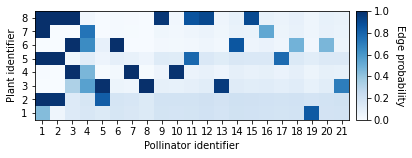

In [16]:
plt.figure(figsize=(6,2))

plt.pcolormesh(edge_prob, cmap=plt.cm.Blues, vmin=0, vmax=1)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge probability', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


The parameters themselves are contained in the `samples` object:

In [17]:
samples['rho']

array([[0.17160997, 0.22368791, 0.35820256, ..., 0.17937457, 0.24069787,
        0.21457808]])

So we can, for example, visualize posterior distributions as:

Text(0, 0.5, 'Count')

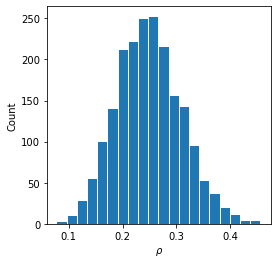

In [18]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'][0], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')

And find posterior averages with:

In [19]:
print('Posterior average of the connectance:', np.mean(samples['rho'][0], axis=0))

Posterior average of the connectance: 0.24935325951452153


The same thing goes for, say, the plant abundances (now a dimension `n_p * samples` object---hence why we average along the axis 1, the `samples` axis):

In [20]:
mean_sigma = np.mean(samples['sigma'], axis=1)

Text(0, 0.5, 'Effective abundance')

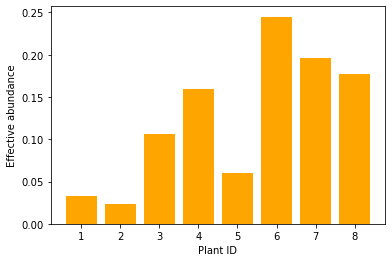

In [21]:
plt.bar([i + 1 for i in range(n_p)], mean_sigma, color='orange')
plt.xlabel('Plant ID')
plt.ylabel('Effective abundance')

We can do the same with the pollinators:

In [22]:
mean_tau = np.mean(samples['tau'], axis=1)

Text(0, 0.5, 'Effective abundance')

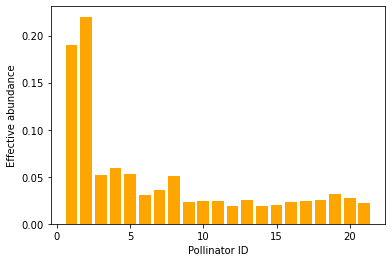

In [23]:
plt.bar([i + 1 for i in range(n_a)], mean_tau, color='orange')
plt.xlabel('Pollinator ID')
plt.ylabel('Effective abundance')

The last thing we'll calculate is the posterior distribution of **some arbitrary function** of the incidence matrix.

To make this example simple, we'll consider the number of non-zero entries, i.e.,

$$f(B) = \sum_{ij} B_{ij}$$

The python definition of this function is simple:

In [24]:
def edge_sum(B):
    return np.sum(B)

Again, we provide a simpler interface to make the calculation:

In [25]:
posterior_values_edge_sum = pp.get_network_property_distribution(samples, edge_sum)

We find, in this case:

Text(0, 0.5, 'Count')

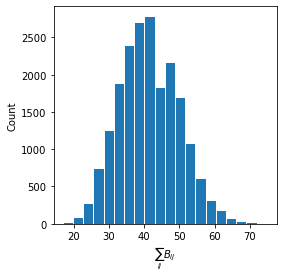

In [26]:
plt.figure(figsize=(4,4))
plt.hist(posterior_values_edge_sum, density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\sum_{ij} B_{ij}$')
plt.ylabel('Count')

# Further information: 

"*[Reconstruction of plant–pollinator networks from observational data](https://doi.org/10.1038/s41467-021-24149-x)*"<br/>
[J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/)<br/>
Nature Communications **12**, 3911 (2021)


Or get in touch at <jean-gabriel.young@uvm.edu> and on [github](https://github.com/jg-you/plant-pol-inference)!